In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
from PIL import Image, ImageOps
#Image.MAX_IMAGE_PIXELS = 5000000000 
import os
import gc
import cv2
import torch
from torch import nn as nn
import shutil
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms as tt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from skimage import io
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
random_seedushka = 1

In [3]:
#random.seed(random_seedushka)
np.random.seed(random_seedushka)
torch.manual_seed(random_seedushka)
torch.cuda.manual_seed(random_seedushka)
torch.backends.cudnn.deterministic = True

In [4]:
class ImgDataset(Dataset):
    def __init__(self, CE_image_paths , LAA_image_paths, root_path,  transform=None):
        self.CE_image_paths = CE_image_paths
        self.LAA_image_paths = LAA_image_paths
        self.transform = transform
        self.all_images = self.CE_image_paths + self.LAA_image_paths
        #self.first = len(CE_image_paths)
        #self.second = len(self.all_images)
        self.length = len(CE_image_paths)+len(LAA_image_paths)
        
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        img_name, label = self.all_images[index]
        
        image = np.asarray(Image.open(img_name))
        

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
CE_path = "../input/mayo-clinic/First Experiment/train/CE"
LAA_path = "../input/mayo-clinic/First Experiment/train/LAA"

In [6]:
CE_images = os.listdir(CE_path)
LAA_images = os.listdir(LAA_path)
root_path = "../input/mayo-clinic/First Experiment/train/"


transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize((512,512))
            ])



In [7]:
LAA_image_paths = [(root_path + "LAA/" + x, torch.tensor([1]).float()) for x in LAA_images]
CE_image_paths = [(root_path + "CE/" + x, torch.tensor([0]).float()) for x in CE_images]

In [8]:
def clean_dataset(paths, val = 219):
    indx = []
    for idx, (im_name, _)  in enumerate(paths):
        a = np.asarray(Image.open(im_name))
        if (a == val).all():
            indx.append(idx)
    copied = np.array(paths)

    copied = np.delete(copied, indx,0)
    return copied.tolist()

In [9]:
#CE_image_paths = clean_dataset(CE_image_paths)
#LAA_image_paths = clean_dataset(LAA_image_paths)

In [10]:
all_images = CE_image_paths + LAA_image_paths

In [11]:
def show_images(k=10):
    plt.figure(figsize=(10, 10))
    for i in range(k):
        img_name = CE_image_paths[i][0]
        image = np.asarray(Image.open(img_name))
        plt.subplot(2,5,i+1)
        plt.imshow(image,interpolation='antialiased')

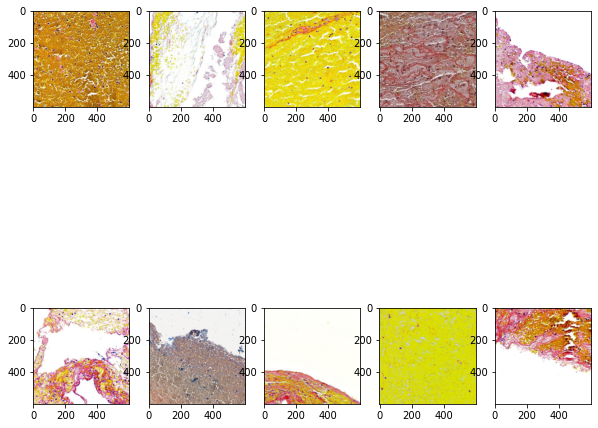

In [12]:
show_images()

In [13]:
print(f"CE: {len(CE_image_paths)} LAA: {len(LAA_image_paths)}")

CE: 81630 LAA: 43207


In [14]:
dataset = ImgDataset(CE_image_paths, LAA_image_paths, root_path, transform)

In [15]:
dataset[0][0].numpy()[0].shape

(512, 512)

In [16]:
val_size = int(len(all_images)*0.2)
train_size = len(all_images)- int(len(all_images)*0.2)

In [17]:
testing = True
testing_num = 5000
if testing:
    dataset = ImgDataset(CE_image_paths[:testing_num], LAA_image_paths[:testing_num], root_path, transform)
    val_size = int(len(all_images[:testing_num])*0.2) * 2
    train_size = 2*(len(all_images[:testing_num])- int(len(all_images[:testing_num])*0.2))

In [18]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_size,val_size])

In [19]:
print(f"train: {len(train_set)} test: {len(test_set)}")

train: 8000 test: 2000


In [20]:
BATCH_SIZE = 16

In [21]:
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers = 3)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers = 3)

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [23]:

"""
model = torchvision.models.resnet.resnet50()

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=256, bias=True),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=256, out_features=1, bias=True)    
)
"""

'\nmodel = torchvision.models.resnet.resnet50()\n\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\nmodel.fc = nn.Sequential(\n    nn.Linear(in_features=2048, out_features=256, bias=True),\n    nn.BatchNorm1d(256),\n    nn.Dropout(p=0.25),\n    nn.Linear(in_features=256, out_features=1, bias=True)    \n)\n'

In [24]:
"""
model = torchvision.models.resnet.resnet50()

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
"""


'\nmodel = torchvision.models.resnet.resnet50()\n\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\nmodel.fc = nn.Linear(in_features=2048, out_features=1, bias=True)\n'

In [25]:
"""
model = torchvision.models.resnet.resnet50()

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=128, bias=True),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=128, out_features=1, bias=True))
"""

'\nmodel = torchvision.models.resnet.resnet50()\n\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\nmodel.fc = nn.Sequential(\n    nn.Linear(in_features=2048, out_features=128, bias=True),\n    nn.BatchNorm1d(128),\n    nn.Dropout(p=0.3),\n    nn.Linear(in_features=128, out_features=1, bias=True))\n'

In [26]:
"""
model = torchvision.models.resnet.resnet34()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=128, out_features=1, bias=True)
)
"""



'\nmodel = torchvision.models.resnet.resnet34()\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\nmodel.fc = nn.Sequential(\n    nn.Linear(in_features=512, out_features=128, bias=True),\n    nn.BatchNorm1d(128),\n    nn.Dropout(p=0.25),\n    nn.Linear(in_features=128, out_features=1, bias=True)\n)\n'

In [27]:
"""
model = torchvision.models.resnet.resnet18()

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
"""



'\nmodel = torchvision.models.resnet.resnet18()\n\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\nmodel.fc = nn.Linear(in_features=512, out_features=1, bias=True)\n'

In [28]:
"""
model = torchvision.models.efficientnet_b3(pretrained=False)
model.features[0][0]= nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(1536, 1)
"""

'\nmodel = torchvision.models.efficientnet_b3(pretrained=False)\nmodel.features[0][0]= nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)\nmodel.classifier[1] = nn.Linear(1536, 1)\n'

In [29]:

model = torchvision.models.efficientnet_b0(pretrained=False)
model.features[0][0]= nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(1280, 1, bias=True)

In [30]:
warmup = False
lrdown = False

In [31]:
LEARNING_RATE = 0.1 * (BATCH_SIZE / 256)
N_EPOCHS = 50
DECAY_RATE = 0.1

In [32]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.AdamW(model.parameters(), lr= LEARNING_RATE, amsgrad=True)#LEARNING_RATE, amsgrad=False, weight_decay=DECAY_RATE)
#optimizer = optim.SGD(model.parameters(), lr= LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE* 5e-3, weight_decay=DECAY_RATE)
scheduler_start = False
if warmup:
    for g in optimizer.param_groups:
        g['lr'] *= 1e-5
    scheduler_start = lr_scheduler.MultiStepLR(optimizer, milestones=[1,2,3,4,5], gamma=10.0, last_epoch = -1)


scheduler_end = lr_scheduler.CosineAnnealingLR(optimizer, T_max = N_EPOCHS, verbose=True) \
                            if lrdown else False

model = model.to(DEVICE)

In [33]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

sigmoid = nn.Sigmoid()

In [34]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        #loss.backward()
        scaler.scale(loss).backward()
        #optimizer.step()
        scaler.step(optimizer)
        
        scaler.update()
        
        outputs = sigmoid(outputs.data)
        preds = (outputs.flatten() >= 0.5).float()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum((preds == labels.data.flatten()),0)
        processed_data += inputs.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().double() / processed_data
    return train_loss, train_acc

In [35]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = (outputs.flatten() >= 0.5).float()
        
        outputs = sigmoid(outputs.data)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum((preds == labels.data.flatten()),0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().double() / processed_size
    return val_loss, val_acc

In [36]:
def train(train_loader, val_loader, model):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    last_acc = 0

    with tqdm(desc="epoch", total=N_EPOCHS) as pbar_outer:

        for epoch in range(N_EPOCHS):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > last_acc:
                last_acc = val_acc
                torch.save(model.state_dict(), str(epoch+1)+TRAIN_PATH)
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if warmup:
                scheduler_start.step()
            if lrdown:
                scheduler_end.step()
            
    return history

In [37]:
TRAIN_PATH = "running_checkpoint.pt"

In [38]:
history = train(train_loader, test_loader, model)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 0.6890376077890397


epoch:   2%|▏         | 1/50 [04:34<3:44:17, 274.64s/it]


Epoch 001 train_loss: 0.6890     val_loss 0.6842 train_acc 0.5421 val_acc 0.5105
loss 0.6785891275405884


epoch:   4%|▍         | 2/50 [08:33<3:22:43, 253.42s/it]


Epoch 002 train_loss: 0.6786     val_loss 0.6829 train_acc 0.5746 val_acc 0.5165
loss 0.6685338425636291


epoch:   6%|▌         | 3/50 [12:37<3:15:22, 249.42s/it]


Epoch 003 train_loss: 0.6685     val_loss 0.6611 train_acc 0.5945 val_acc 0.5705
loss 0.6688069527149201


epoch:   8%|▊         | 4/50 [16:38<3:08:39, 246.09s/it]


Epoch 004 train_loss: 0.6688     val_loss 0.6568 train_acc 0.5941 val_acc 0.6015
loss 0.6636808571815491


epoch:  10%|█         | 5/50 [20:36<3:02:09, 242.87s/it]


Epoch 005 train_loss: 0.6637     val_loss 0.6402 train_acc 0.6064 val_acc 0.5865
loss 0.6651752687692642


epoch:  12%|█▏        | 6/50 [24:38<2:57:58, 242.69s/it]


Epoch 006 train_loss: 0.6652     val_loss 0.6507 train_acc 0.6034 val_acc 0.5630
loss 0.6608425040841103


epoch:  14%|█▍        | 7/50 [28:35<2:52:41, 240.97s/it]


Epoch 007 train_loss: 0.6608     val_loss 0.6606 train_acc 0.6111 val_acc 0.5750
loss 0.6564372145533561


epoch:  16%|█▌        | 8/50 [32:31<2:47:34, 239.39s/it]


Epoch 008 train_loss: 0.6564     val_loss 0.6275 train_acc 0.6189 val_acc 0.5890
loss 0.6531242181062699


epoch:  18%|█▊        | 9/50 [36:29<2:43:15, 238.91s/it]


Epoch 009 train_loss: 0.6531     val_loss 0.6480 train_acc 0.6211 val_acc 0.6030
loss 0.6491326312422753


epoch:  20%|██        | 10/50 [40:27<2:39:02, 238.56s/it]


Epoch 010 train_loss: 0.6491     val_loss 0.6330 train_acc 0.6329 val_acc 0.5925
loss 0.64522440046072


epoch:  22%|██▏       | 11/50 [44:28<2:35:33, 239.33s/it]


Epoch 011 train_loss: 0.6452     val_loss 0.6275 train_acc 0.6311 val_acc 0.6000
loss 0.6349696983098984


epoch:  24%|██▍       | 12/50 [48:24<2:31:01, 238.46s/it]


Epoch 012 train_loss: 0.6350     val_loss 0.6383 train_acc 0.6418 val_acc 0.5865
loss 0.6275412952899933


epoch:  26%|██▌       | 13/50 [52:21<2:26:38, 237.81s/it]


Epoch 013 train_loss: 0.6275     val_loss 0.6963 train_acc 0.6569 val_acc 0.5235
loss 0.6031902092695236


epoch:  28%|██▊       | 14/50 [56:18<2:22:36, 237.69s/it]


Epoch 014 train_loss: 0.6032     val_loss 0.6329 train_acc 0.6793 val_acc 0.6275
loss 0.561530503809452


epoch:  30%|███       | 15/50 [1:00:15<2:18:29, 237.41s/it]


Epoch 015 train_loss: 0.5615     val_loss 0.6687 train_acc 0.7119 val_acc 0.5895
loss 0.49398317447304724


epoch:  32%|███▏      | 16/50 [1:04:15<2:14:55, 238.11s/it]


Epoch 016 train_loss: 0.4940     val_loss 0.6933 train_acc 0.7649 val_acc 0.6215
loss 0.4279047427177429


epoch:  34%|███▍      | 17/50 [1:08:12<2:10:47, 237.81s/it]


Epoch 017 train_loss: 0.4279     val_loss 0.7412 train_acc 0.8049 val_acc 0.6110
loss 0.3784375833272934


epoch:  36%|███▌      | 18/50 [1:12:12<2:07:13, 238.56s/it]


Epoch 018 train_loss: 0.3784     val_loss 0.7952 train_acc 0.8245 val_acc 0.6065
loss 0.338308432251215


epoch:  38%|███▊      | 19/50 [1:16:12<2:03:26, 238.91s/it]


Epoch 019 train_loss: 0.3383     val_loss 0.8709 train_acc 0.8501 val_acc 0.5730
loss 0.3045918559581041


epoch:  40%|████      | 20/50 [1:20:09<1:59:08, 238.29s/it]


Epoch 020 train_loss: 0.3046     val_loss 0.9589 train_acc 0.8648 val_acc 0.5830
loss 0.29174588042497634


epoch:  42%|████▏     | 21/50 [1:24:04<1:54:40, 237.25s/it]


Epoch 021 train_loss: 0.2917     val_loss 0.9717 train_acc 0.8752 val_acc 0.6225
loss 0.27149746546149256


epoch:  44%|████▍     | 22/50 [1:27:59<1:50:24, 236.59s/it]


Epoch 022 train_loss: 0.2715     val_loss 0.9458 train_acc 0.8841 val_acc 0.5735
loss 0.2581665475443006


epoch:  46%|████▌     | 23/50 [1:31:55<1:46:27, 236.58s/it]


Epoch 023 train_loss: 0.2582     val_loss 1.0900 train_acc 0.8932 val_acc 0.6135
loss 0.23978525422513486


epoch:  48%|████▊     | 24/50 [1:35:54<1:42:48, 237.24s/it]


Epoch 024 train_loss: 0.2398     val_loss 1.0622 train_acc 0.9025 val_acc 0.5560
loss 0.23122897593677044


epoch:  50%|█████     | 25/50 [1:39:48<1:38:29, 236.38s/it]


Epoch 025 train_loss: 0.2312     val_loss 0.9514 train_acc 0.9058 val_acc 0.5580
loss 0.23344171485304832


epoch:  52%|█████▏    | 26/50 [1:43:44<1:34:29, 236.23s/it]


Epoch 026 train_loss: 0.2334     val_loss 1.0029 train_acc 0.9046 val_acc 0.5665
loss 0.22982273330539466


epoch:  54%|█████▍    | 27/50 [1:47:39<1:30:25, 235.90s/it]


Epoch 027 train_loss: 0.2298     val_loss 0.9207 train_acc 0.9085 val_acc 0.5835
loss 0.21149245687574147


epoch:  56%|█████▌    | 28/50 [1:51:35<1:26:29, 235.91s/it]


Epoch 028 train_loss: 0.2115     val_loss 1.3647 train_acc 0.9129 val_acc 0.5755
loss 0.21993905007094144


epoch:  58%|█████▊    | 29/50 [1:55:32<1:22:40, 236.23s/it]


Epoch 029 train_loss: 0.2199     val_loss 1.1716 train_acc 0.9107 val_acc 0.5620
loss 0.20316881865262984


epoch:  60%|██████    | 30/50 [1:59:29<1:18:46, 236.34s/it]


Epoch 030 train_loss: 0.2032     val_loss 1.0995 train_acc 0.9193 val_acc 0.5610
loss 0.21337902200967074


epoch:  62%|██████▏   | 31/50 [2:03:31<1:15:26, 238.23s/it]


Epoch 031 train_loss: 0.2134     val_loss 1.0535 train_acc 0.9136 val_acc 0.5780
loss 0.19610362108796836


epoch:  64%|██████▍   | 32/50 [2:07:26<1:11:10, 237.22s/it]


Epoch 032 train_loss: 0.1961     val_loss 1.0706 train_acc 0.9199 val_acc 0.6030
loss 0.1985424093566835


epoch:  66%|██████▌   | 33/50 [2:11:22<1:07:04, 236.74s/it]


Epoch 033 train_loss: 0.1985     val_loss 0.9386 train_acc 0.9217 val_acc 0.5825
loss 0.20827597149461508


epoch:  68%|██████▊   | 34/50 [2:15:17<1:03:00, 236.31s/it]


Epoch 034 train_loss: 0.2083     val_loss 0.9443 train_acc 0.9183 val_acc 0.5790
loss 0.2067353815585375


epoch:  70%|███████   | 35/50 [2:19:17<59:18, 237.22s/it]


Epoch 035 train_loss: 0.2067     val_loss 0.9791 train_acc 0.9165 val_acc 0.5685
loss 0.1919432689845562


epoch:  72%|███████▏  | 36/50 [2:23:13<55:16, 236.90s/it]


Epoch 036 train_loss: 0.1919     val_loss 1.2101 train_acc 0.9211 val_acc 0.5705
loss 0.20010359524190427


epoch:  74%|███████▍  | 37/50 [2:27:15<51:42, 238.66s/it]


Epoch 037 train_loss: 0.2001     val_loss 1.0910 train_acc 0.9211 val_acc 0.5510
loss 0.1971211454719305


epoch:  76%|███████▌  | 38/50 [2:31:15<47:48, 239.06s/it]


Epoch 038 train_loss: 0.1971     val_loss 1.1145 train_acc 0.9207 val_acc 0.5530
loss 0.2014712328836322


epoch:  78%|███████▊  | 39/50 [2:35:12<43:41, 238.31s/it]


Epoch 039 train_loss: 0.2015     val_loss 1.2307 train_acc 0.9217 val_acc 0.5490
loss 0.19264076347649098


epoch:  80%|████████  | 40/50 [2:39:08<39:35, 237.59s/it]


Epoch 040 train_loss: 0.1926     val_loss 1.1132 train_acc 0.9237 val_acc 0.5735
loss 0.20214299800246954


epoch:  82%|████████▏ | 41/50 [2:43:12<35:56, 239.63s/it]


Epoch 041 train_loss: 0.2021     val_loss 1.1594 train_acc 0.9199 val_acc 0.5535
loss 0.19575544783845544


epoch:  84%|████████▍ | 42/50 [2:47:12<31:58, 239.78s/it]


Epoch 042 train_loss: 0.1958     val_loss 1.2309 train_acc 0.9223 val_acc 0.5530
loss 0.18289119851589203


epoch:  86%|████████▌ | 43/50 [2:51:09<27:51, 238.79s/it]


Epoch 043 train_loss: 0.1829     val_loss 0.9433 train_acc 0.9313 val_acc 0.5465
loss 0.1909405935704708


epoch:  88%|████████▊ | 44/50 [2:55:06<23:49, 238.21s/it]


Epoch 044 train_loss: 0.1909     val_loss 1.0590 train_acc 0.9254 val_acc 0.5470
loss 0.1922057539448142


epoch:  90%|█████████ | 45/50 [2:59:05<19:53, 238.64s/it]


Epoch 045 train_loss: 0.1922     val_loss 1.1360 train_acc 0.9257 val_acc 0.5600
loss 0.19082968173921108


epoch:  92%|█████████▏| 46/50 [3:03:08<15:58, 239.70s/it]


Epoch 046 train_loss: 0.1908     val_loss 1.3728 train_acc 0.9266 val_acc 0.5630
loss 0.1884261662438512


epoch:  94%|█████████▍| 47/50 [3:07:12<12:03, 241.23s/it]


Epoch 047 train_loss: 0.1884     val_loss 1.0674 train_acc 0.9313 val_acc 0.5625
loss 0.19522661965340377


epoch:  96%|█████████▌| 48/50 [3:11:07<07:58, 239.38s/it]


Epoch 048 train_loss: 0.1952     val_loss 1.1090 train_acc 0.9254 val_acc 0.5790
loss 0.20012850122153758


epoch:  98%|█████████▊| 49/50 [3:15:02<03:57, 237.89s/it]


Epoch 049 train_loss: 0.2001     val_loss 0.9982 train_acc 0.9253 val_acc 0.5780
loss 0.1993083382099867


epoch: 100%|██████████| 50/50 [3:18:56<00:00, 238.74s/it]


Epoch 050 train_loss: 0.1993     val_loss 1.1153 train_acc 0.9301 val_acc 0.5710


In [39]:
!mkdir /kaggle/test

In [40]:
def slicing(image_path, window_size = 512):
    img = Image.open(image_path)
    img_ar = np.array(img)
    
    x_limit = img_ar.shape[0] // window_size
    y_limit = img_ar.shape[1] // window_size

    for i in range(x_limit):
        for j in range(y_limit):
            slice_ = img_ar[window_size*i:window_size*(i+1),window_size*j:window_size*(j+1),:]
            mean = slice_.mean()

            if mean < 230:
                
                im = Image.fromarray(slice_)
                im.save(f"/kaggle/test/{image_path[-12:-4]}/{image_path[-12:-4]}:{i}-{j}.jpeg")

                del im, slice_ 
                gc.collect()

            else:
                
                del slice_ 
                gc.collect()

    del img_ar, img, x_limit, y_limit, mean, i, j, genaral_mean  
    gc.collect()

In [41]:
#window_size = 1024
#test_images = os.listdir("/kaggle/input/mayo-clinic-strip-ai/test")

#for i in test_images:
#    print(i+': \n')
#    path = test_paths + '/' + i
#    slicing(i, window_size = window_size)